In [23]:
from __future__ import absolute_import, division, print_function

import pathlib

import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [24]:
dataset_path = keras.utils.get_file("auto-mpg.data", "https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")
dataset_path

'/Users/unlimitediw/.keras/datasets/auto-mpg.data'

In [25]:
column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight',
                'Acceleration', 'Model Year', 'Origin'] 
raw_dataset = pd.read_csv(dataset_path, names = column_names, na_values = "?",comment = "\t",sep = " ",skipinitialspace = True)
dataset = raw_dataset.copy()
dataset.head()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
0,18.0,8,307.0,130.0,3504.0,12.0,70,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,1


In [26]:
# return a boolean same-sized object indicating if the values are NA
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [27]:
dataset = dataset.dropna()

In [28]:
origin = dataset.pop('Origin')

In [29]:
# change the origin categorical feature to one-hot
dataset['USA'] = (origin == 1)*1.0
dataset['Europe'] = (origin == 2)*1.0
dataset['Japan'] = (origin == 3)*1.0
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
393,27.0,4,140.0,86.0,2790.0,15.6,82,1.0,0.0,0.0
394,44.0,4,97.0,52.0,2130.0,24.6,82,0.0,1.0,0.0
395,32.0,4,135.0,84.0,2295.0,11.6,82,1.0,0.0,0.0
396,28.0,4,120.0,79.0,2625.0,18.6,82,1.0,0.0,0.0
397,31.0,4,119.0,82.0,2720.0,19.4,82,1.0,0.0,0.0


In [30]:
train_dataset = dataset.sample(frac=0.8,random_state = 0)
test_dataset = dataset.drop(train_dataset.index)

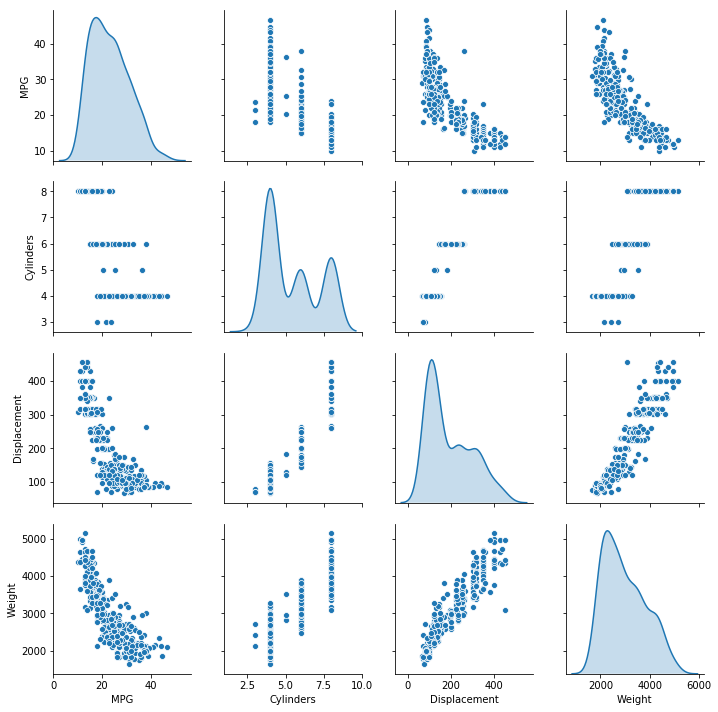

In [31]:
sns.pairplot(train_dataset[['MPG','Cylinders','Displacement','Weight']],diag_kind='kde')

In [32]:
train_stats = train_dataset.describe()
train_stats.pop('MPG')
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0


In [33]:
# Find MPG
train_labels = train_dataset.pop('MPG')
test_labels = test_dataset.pop('MPG')

def norm(x):
    return (x-train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

In [34]:
# Sequential: configures the model for training
# keras.layers.Dense: regular densely-connected NN layer
def build_model():
    model = keras.Sequential([
        layers.Dense(64, activation = tf.nn.relu, input_shape =[len(train_dataset.keys())]),
        layers.Dense(64, activation = tf.nn.relu),
        layers.Dense(1)
    ])
    
    # RMSprop optimizer is similar to the gradient descent algorithm with momentum which restrics the oscillations in the vertical direction. It is a good choice for recurrent neural netw
    optimizer = tf.keras.optimizers.RMSprop(0.001)
    model.compile(loss='mean_squared_error', optimizer = optimizer, metrics = ['mean_absolute_error','mean_squared_error'])
    return model

In [35]:
model = build_model()

In [36]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 64)                640       
_________________________________________________________________
dense_4 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________


In [37]:
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

array([[ 0.09035192],
       [ 0.12950985],
       [ 0.17489153],
       [ 0.19570771],
       [ 0.07102983],
       [ 0.09963492],
       [ 0.06215025],
       [ 0.1518154 ],
       [-0.01276691],
       [ 0.11831401]], dtype=float32)

In [39]:
# training info: callback
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('')
        print('.',end ='')

EPOCHS = 1000

history = model.fit(
    normed_train_data,train_labels,
    epochs = EPOCHS, validation_split = 0.2,verbose =0,
    callbacks = [PrintDot()]
)

Instructions for updating:
Use tf.cast instead.

....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................

In [40]:
# show training history
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mean_absolute_error,mean_squared_error,val_loss,val_mean_absolute_error,val_mean_squared_error,epoch
995,2.387092,0.937653,2.387093,8.406150,2.201910,8.406149,995
996,2.467439,0.951843,2.467439,8.504871,2.236074,8.504871,996
997,2.515506,0.987456,2.515506,8.544674,2.204270,8.544674,997
998,2.417237,0.945609,2.417237,8.741803,2.213539,8.741804,998
999,2.344355,0.919683,2.344356,8.676719,2.226252,8.676719,999


In [41]:
# visualize history training error
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
    
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [MPG]')
    plt.plot(hist['epoch'],hist['mean_absolute_error'],label ='Train Error')
    plt.plot(hist['epoch'],hist['val_mean_absolute_error'],label = 'Val Error')
    plt.ylim([0,5])
    plt.legend()
    
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error [$MPG^2$]')
    plt.plot(hist['epoch'], hist['mean_squared_error'],label = ['Train Error'])
    plt.plot(hist['epoch'], hist['val_mean_squared_error'],label = 'Val Error')
    plt.ylim([0,20])
    plt.legend()
    
    plt.show()

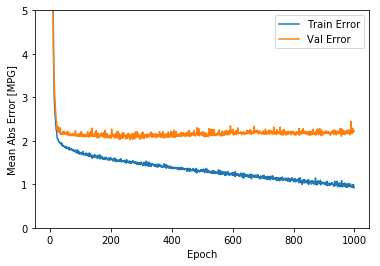

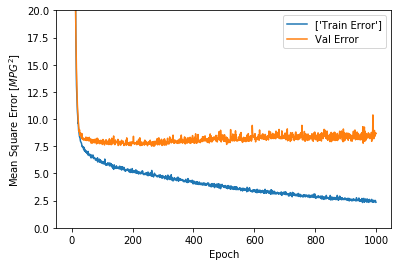

In [43]:
plot_history(history)


.............................................

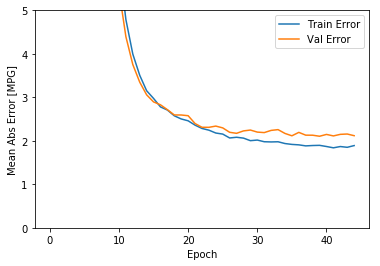

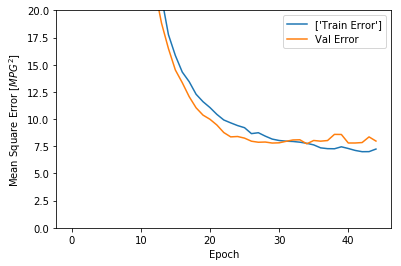

In [44]:
model = build_model()
# patience: the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss',patience = 10)
history = model.fit(normed_train_data, train_labels, epochs=EPOCHS,
                    validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])
plot_history(history)

In [45]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=0)

print("Testing set Mean Abs Error: {:5.2f} MPG".format(mae))

Testing set Mean Abs Error:  1.87 MPG


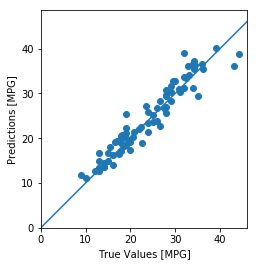

In [49]:
# visualization of performance
test_predictions = model.predict(normed_test_data).flatten()

plt.scatter(test_labels,test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100,100],[-100,100])

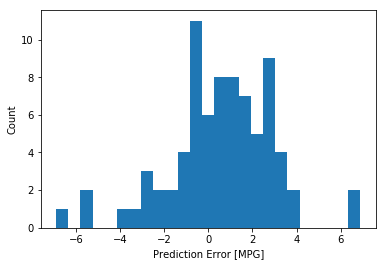

In [50]:
error = test_predictions - test_labels
plt.hist(error,bins = 25)
plt.xlabel('Prediction Error [MPG]')
_ = plt.ylabel("Count")

In [ ]:
'''
### Conclusion
* MSE is a common loss function for regression
* Similarly, evaluation metrics used for regression differ from classification.
A common regression metric is Mean Absolute Error(MAE).
* When numeric input data features have values with different ranges, each feature should be scaled independently to the same range
* If there is not much training data, one technique is to prefer a small network with few hidden layers to avoid overfitting
* Early stopping also prevents overfitting.
'''